In [39]:
from datetime import datetime 
import time 
import pandas as pd 
import requests
import re
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
import matplotlib as mpl
import scipy.sparse
from sklearn.decomposition import PCA


%matplotlib inline

In [40]:
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from scipy import stats

In [41]:
url = 'https://www.reddit.com/hot.json'

In [42]:
header = {'User-agent': 'el muneco'}

In [43]:
res = requests.get(url, headers=header)
res

<Response [200]>

In [44]:
def scrape_reddit_posts(url_tag, header, loops, waittime, filename): 
    posts = []
    after = None
    for i in range(loops):
        print(i)
        if after == None:
            params = {}
        else:
            params = {'after': after}
        url = 'https://www.reddit.com/r/'+url_tag
        res = requests.get(url,params=params,header=header)
        if res.status_code == 200:

            data_json = res.json()
            after = data_json['data']['after']
            for row in data_json['data']['children']:
                post = {}
                post['subreddit'] = row['data']['subreddit']
                post['title'] = row['data']['title']
                post['num_comments'] = row['data']['num_comments']
                post['ups'] = row['data']['ups']
                post['downs'] = row['data']['downs']
                post['likes'] = row['data']['likes']
                post['score'] = row['data']['score']
                post['view_count'] = row['data']['view_count']
                post['url'] = row['data']['url']
                post['time_of_pull'] = datetime.now()
                posts.append(post)
        else:
            print(res.status_code)
            break
        time.sleep(waittime)   
    df = pd.DataFrame(posts)
    now = datetime.now()
    df.to_csv(filename+now.strftime('%Y%m%d%H%S'),index=False)

In [52]:
#what happens if i run this again? how will my data frame change?
scrape_reddit_posts('football.json',header,40,1.5,'Reddit_football_')

NameError: name 'header' is not defined

In [7]:
nfl

NameError: name 'nfl' is not defined

In [ ]:
scrape_reddit_posts('nfl.json',header,40,1.5,'Reddit_nfl_')

### cleaning and EDA

In [45]:
nfl = pd.read_csv('../data/Reddit_nfl_201812161451')
nfl.drop(columns=['downs', 'likes','view_count'], inplace = True)

In [46]:
fut = pd.read_csv('../data/Reddit_football_201812161530')
fut.drop(columns=['downs', 'likes', 'view_count'], inplace = True)

In [49]:
#how do i treat that emoji?
fut.head(10)

,num_comments,score,subreddit,time_of_pull,title,ups,url
0,0,2,football,2018-12-16 15:21:10.471588,"Weekly /r/Football Discussion - December 11, 2018",2,https://www.reddit.com/r/football/comments/a5a...
1,48,34,football,2018-12-16 15:21:10.471597,Hi 🙂,34,https://www.reddit.com/r/football/comments/a6m...
2,0,2,football,2018-12-16 15:21:10.471599,Match Thread: RB Leipzig vs Mainz [Regular Sea...,2,https://www.reddit.com/r/football/comments/a6p...
3,1,2,football,2018-12-16 15:21:10.471601,Dier injury causes fans to call for January sp...,2,https://www.football.london/tottenham-hotspur-...
4,0,6,football,2018-12-16 15:21:10.471604,Ten Likely January Window Stories and how they...,6,https://theathleteshub.org/2018/12/15/10-poten...
5,12,65,football,2018-12-16 15:21:10.471609,Why River Plate’s Copa Libertadores hero Juan ...,65,https://www.goal.com/en-gb/news/why-wonderkid-...
6,4,9,football,2018-12-16 15:21:10.471612,The evolution of 4-3-3 and its impact on wide ...,9,https://www.elartedf.com/evolution-4-3-3-impac...
7,1,0,football,2018-12-16 15:21:10.471614,Chris Smalling signs a contract extension at M...,0,https://www.dribl.co/articles/breaking:-chris-...
8,4,77,football,2018-12-16 15:21:10.471616,Chelsea face partial stadium closure if Uefa f...,77,https://www.theguardian.com/football/2018/dec/...
9,0,4,football,2018-12-16 15:21:10.471618,Why Laurent Koscielny will prove he is still a...,4,https://www.goal.com/en-gb/news/why-laurent-ko...


In [50]:
nfl.head(10)

,num_comments,score,subreddit,time_of_pull,title,ups,url
0,1009,77,nfl,2018-12-16 14:47:35.865819,Game Thread: RedZone/Game hub (Week 15),77,https://www.reddit.com/r/nfl/comments/a6qmoi/g...
1,62,40,nfl,2018-12-16 14:47:35.865828,"Picture/GIF/Video highlights thread (Week 15, ...",40,https://www.reddit.com/r/nfl/comments/a6qmm0/p...
2,549,6051,nfl,2018-12-16 14:47:35.865830,[Kinkhabwala] #Patriots owner Robert Kraft fle...,6051,https://twitter.com/AKinkhabwala/status/107431...
3,97,1573,nfl,2018-12-16 14:47:35.865832,[Redskins] Alex Smith is finally home from the...,1573,https://twitter.com/Redskins/status/1074325817...
4,90,493,nfl,2018-12-16 14:47:35.865835,[Highlight] Rodger gets sacked by Khalil Mack'...,493,https://streamable.com/20frg
5,48,756,nfl,2018-12-16 14:47:35.865837,[Schefter] Cowboys’ Pro-Bowl guard Zack Martin...,756,https://twitter.com/adamschefter/status/107432...
6,667,6761,nfl,2018-12-16 14:47:35.865839,[Highlight] Peppers sacks Keenum to seal the B...,6761,https://streamable.com/kuvno
7,163,395,nfl,2018-12-16 14:47:35.865841,[Rapoport] The #Ravens are going to treat Joe ...,395,https://twitter.com/rapsheet/status/1074346008...
8,268,4037,nfl,2018-12-16 14:47:35.865843,[Koenigsberg] For the first time in more than ...,4037,https://twitter.com/RyanKoenigsberg/status/107...
9,69,337,nfl,2018-12-16 14:47:35.865845,"[Dvorak] During a previous Jags/Skins game, Da...",337,https://twitter.com/CurtisDvorak/status/107434...


In [51]:
frames = [fut,nfl]
df = pd.concat(frames)

In [52]:
df['is_juve'] = df['subreddit'].map(lambda x: 1 if x == 'football' else 0)

In [53]:
df.head()

,num_comments,score,subreddit,time_of_pull,title,ups,url,is_juve
0,0,2,football,2018-12-16 15:21:10.471588,"Weekly /r/Football Discussion - December 11, 2018",2,https://www.reddit.com/r/football/comments/a5a...,1
1,48,34,football,2018-12-16 15:21:10.471597,Hi 🙂,34,https://www.reddit.com/r/football/comments/a6m...,1
2,0,2,football,2018-12-16 15:21:10.471599,Match Thread: RB Leipzig vs Mainz [Regular Sea...,2,https://www.reddit.com/r/football/comments/a6p...,1
3,1,2,football,2018-12-16 15:21:10.471601,Dier injury causes fans to call for January sp...,2,https://www.football.london/tottenham-hotspur-...,1
4,0,6,football,2018-12-16 15:21:10.471604,Ten Likely January Window Stories and how they...,6,https://theathleteshub.org/2018/12/15/10-poten...,1


In [54]:
#this is good, pretty even classification 
df['subreddit'].value_counts(normalize=False)

nfl         999
football    984
Name: subreddit, dtype: int64

In [16]:
df[['football' in each.lower() for each in df['title']]].groupby('subreddit').count()

,num_comments,score,time_of_pull,title,ups,url,is_juve
subreddit,,,,,,,
football,189,189,189,189,189,189,189
nfl,28,28,28,28,28,28,28


In [18]:
[title for title in df[df['subreddit'] == 'nfl']['title']]

['Game Thread: RedZone/Game hub (Week 15)',
 'Picture/GIF/Video highlights thread (Week 15, Sunday)',
 '[Kinkhabwala] #Patriots owner Robert Kraft flew in to Pittsburgh early yesterday to visit the Tree of Life synagogue, where a gunman massacred 11 people. He then attended services at Rodef Shalom, and when invited to speak by the rabbi, he did. I’m told he even spoke partly in Hebrew. #bridges',
 '[Redskins] Alex Smith is finally home from the Hospital',
 "[Highlight] Rodger gets sacked by Khalil Mack's back",
 '[Schefter] Cowboys’ Pro-Bowl guard Zack Martin will miss the first football game at any level of career today in Indianapolis. Never missed one in high school, at Notre Dame, or in NFL.',
 '[Highlight] Peppers sacks Keenum to seal the Browns win',
 '[Rapoport] The #Ravens are going to treat Joe Flacco with class and trading him to a team of his choice is also possible (and his salary makes that doable).',
 '[Koenigsberg] For the first time in more than 10,000 days, the Clevel

In [19]:
[title for title in df[df['subreddit'] == 'football']['title'] if 'football' in title.lower()]

['Weekly /r/Football Discussion - December 11, 2018',
 'Football streaming?',
 'Crazy dudes doing football tricks in mid-air',
 'Should I join a football club?',
 'Lost of Interest to watch real madrid champions league in 18/19 maybe because that ronaldo left to juventus or not. Maybe that i am losing interest of football since ronaldo left, and no more rival between messi and ronaldo since i watch from 2011.',
 'Football walkout song poll',
 'The Data Day: Awesome Azpi | Official Site | Chelsea Football Club',
 'River Plate 3-1 Boca Juniors (5-3 agg): Copa Libertadores final, second leg – live! | Football',
 'Why Do You Wear Football Kits?',
 'Neymar wants to play in England - Football News Scorenga UK',
 'The man who dribbled into battle: a previously untold story of football in WWI',
 "City can't always play fantasy football, says Kompany as the champions beat Watford",
 "'A brighter future for amputee football: Owen Coyle Jr discusses why he only sees growth for the sport'",
 'Foot

In [23]:
CR7=(len(df[df['title'].str.contains('Ronaldo')]['title']))

Messi= (len(df[df['title'].str.contains('Messi')]['title']))

print(f'Messi was found in {Messi} post titles')
print('')
print(f'Cristiano was found in {CR7} post titles')


Messi was found in 27 post titles

Cristiano was found in 31 post titles


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1983 entries, 0 to 998
Data columns (total 8 columns):
num_comments    1983 non-null int64
score           1983 non-null int64
subreddit       1983 non-null object
time_of_pull    1983 non-null object
title           1983 non-null object
ups             1983 non-null int64
url             1983 non-null object
is_juve         1983 non-null int64
dtypes: int64(4), object(4)
memory usage: 139.4+ KB


In [27]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_comments,1983.0,108.003026,730.484308,0.0,2.0,13.0,48.0,23801.0
score,1983.0,260.022189,975.844598,0.0,2.0,18.0,88.0,12408.0
is_juve,1983.0,0.496218,0.500112,0.0,0.0,0.0,1.0,1.0


In [26]:
#ups and score have the same values... ill drop ups
df.drop('ups', axis=1,inplace=True)

### Splitting my X

In [28]:
#setting up X and y
X = df['title']
y = df['is_juve']

In [29]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=.33, stratify=y)

### CountVectorizer

In [118]:
cv = CountVectorizer(stop_words='english')
                     
cv.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [119]:
#removing the noise
from sklearn.feature_extraction import stop_words
len(stop_words.ENGLISH_STOP_WORDS)

318

In [120]:
X_train_cv = cv.transform(X_train)
X_test_cv = cv.transform(X_test)

In [124]:
# count of words, with ngram_range
# pd.DataFrame(X_train_cv.todense(), 
#              columns=cv.get_feature_names()).sum().sort_values(ascending=False).head(10)

game thread            22
premier league         20
real madrid            18
champions league       18
week 15                17
manchester city        15
nations league         15
manchester united      14
match thread           13
football discussion    13
dtype: int64

In [121]:
# count of words without ngram_range 
pd.DataFrame(X_train_cv.todense(), 
             columns=cv.get_feature_names()).sum().sort_values(ascending=False).head(10)

football    157
game        130
nfl         115
league       79
season       78
team         66
vs           65
time         61
week         60
games        57
dtype: int64

Modeling

In [122]:
#this is my baseline
y_train.value_counts(normalize=True)[0:1]

0    0.503765
Name: is_juve, dtype: float64

### seeing if i can get a harmonic mean, no bueno
ValueError: Harmonic mean only defined if a
ll elements greater than zero"
```stats.hmean(y_train)```

### LogisReg

In [173]:
lr = LogisticRegressionCV(cv=5, Cs=100)
lr.fit(X_train_cv, y_train)

LogisticRegressionCV(Cs=100, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='warn', n_jobs=None, penalty='l2',
           random_state=None, refit=True, scoring=None, solver='lbfgs',
           tol=0.0001, verbose=0)

In [174]:
lr.score(X_train_cv,y_train), lr.score(X_test_cv, y_test)

(1.0, 0.9480916030534351)

In [167]:
probas = lr.predict_proba(X_train_cv)
scores = pd.DataFrame(probas, columns=['class_1', 'class_2'])
scores.head()

,class_1,class_2
0,0.999990,0.000010
1,0.995999,0.004001
2,0.992331,0.007669
3,0.023547,0.976453
4,0.008375,0.991625


In [ ]:
X_train_text = pd.DataFrame(X_train_cv.todense(), columns=cv.get_feature_names())
X_train_text.head()

### Trying some plots for lr

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


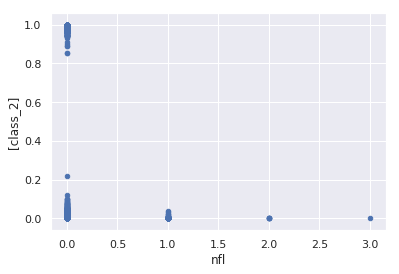

In [168]:
# plot logistic reg's classifiers
text_preds = X_train_text.copy()
text_preds['class_1'] = scores['class_1']
text_preds['class_2'] = scores['class_2']
text_preds.index = y_train

text_preds.sort_values('class_2').plot(kind="scatter", x="nfl", y=['class_2'])

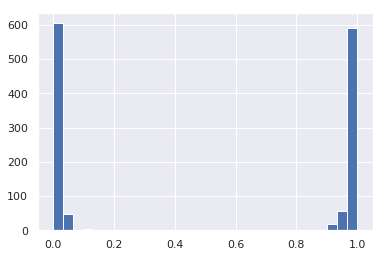

In [169]:
text_preds['class_1'].hist(bins=30, title='Misclassification')
#look at probability of y given X(pick one variable at a time)

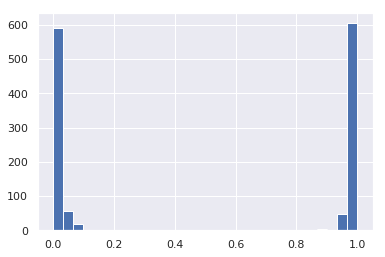

In [171]:
plt.figure()
text_preds['class_2'].hist(bins=30);

In [485]:
# fig, ax = plt.subplots(figsize=(60,60))
# ax.spy(X_train_cv)

### I need help fully understanding this 

In [129]:
y_hat = lr.predict(X_test_cv)
print(classification_report(y_test,y_hat))

              precision    recall  f1-score   support

           0       0.99      0.90      0.95       330
           1       0.91      0.99      0.95       325

   micro avg       0.95      0.95      0.95       655
   macro avg       0.95      0.95      0.95       655
weighted avg       0.95      0.95      0.95       655



### what do i need to do get my FP & FN improved

In [130]:
#confusion matrix, by removing a repeat column i was able to decrease by TN from 25 to 23, but they moved to FP
cm = confusion_matrix(y_test,y_hat)
cm


array([[298,  32],
       [  2, 323]])

In [133]:
lr.coef_[0]

array([ 1.30225800e-01, -6.04964503e-04,  1.66880056e-01, ...,
        1.47508732e-01,  1.07605777e+00,  3.14205585e-01])

In [135]:
import numpy as np

coef_df = pd.DataFrame({
    'coef' : cv.get_feature_names(),
    'val': lr.coef_[0],
    'val_abs': np.abs(lr.coef_[0])
})
coef_df.sort_values('val_abs', ascending=False)

,coef,val,val_abs
2209,nfl,-5.255247e+00,5.255247e+00
1560,highlight,-4.019850e+00,4.019850e+00
354,austrian,-3.874360e+00,3.874360e+00
816,countries,-3.640548e+00,3.640548e+00
1731,jets,-3.247937e+00,3.247937e+00
668,chargers,-3.035122e+00,3.035122e+00
505,bowl,-2.916708e+00,2.916708e+00
2538,qb,-2.754127e+00,2.754127e+00
2419,playoffs,-2.702906e+00,2.702906e+00
3111,sunday,-2.547047e+00,2.547047e+00


In [109]:
#df[df['title'].str.contains('Texans')].head


### Pipe it up

In [58]:
pipe = Pipeline([
    ('cv', CountVectorizer(stop_words= 'english', 
                           ngram_range= (2,2))),
    ('lr', LogisticRegressionCV(cv=5, Cs=100))
])
pipe.fit(X_train, y_train)
pipe.score(X_train, y_train), pipe.score(X_test,y_test)

(0.9879518072289156, 0.899236641221374)

In [59]:
pipe.predict(['football'])

array([0])

### DecisionTree 
    1)use the esemble methods to see how they perform. 
    2)Look at the feature importances.(cant look these up bc its only one tree) 
    3)Sort the values. 

In [60]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,ExtraTreesClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [136]:
tree = DecisionTreeClassifier(max_depth=30)

In [137]:
tree.fit(X_train_cv, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=30,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [138]:
tree.score(X_train_cv, y_train), tree.score(X_test_cv, y_test)

(0.9043674698795181, 0.8305343511450382)

In [139]:
cross_val_score(tree, X_train_cv, y_train, cv=3, error_score='raise').mean()

0.8140097851955508

In [140]:
tree.fit(X_train_cv,y_train)
tree.score(X_train_cv, y_train), tree.score(X_test_cv, y_test)

(0.9043674698795181, 0.8198473282442749)

In [141]:
y_hat = tree.predict_proba(X_test_cv)
scores = pd.DataFrame(y_hat, columns=['class_1', 'class_2'])
scores['y_hat'] = tree.predict(X_test_cv)

# scores.query('y != y_hat')
test_text = pd.DataFrame(X_test_cv.toarray(), columns=cv.get_feature_names())
# test_text.loc[:, 'class_1'] = scores['class_1']
# scores = pd.concat([test_text, scores], axis=1, ignore_index=True)
#scores.index = y_test
# test_text.head()

for col in ['class_1', 'class_2', 'y_hat']:
    test_text[col] = scores[col]

test_text.index = y_test
test_text.head()

,000,004,01,026,03,04,054,09,10,100,...,zimmer,zoff,zone,zrebiec,élber,özil,čech,class_1,class_2,y_hat
is_juve,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.223986,0.776014,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.223986,0.776014,1
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0.223986,0.776014,1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.223986,0.776014,1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1.000000,0.000000,0


In [142]:
columns_select = [col for col in test_text.columns if col not in ['y_hat', 'class_1', 'class_2']]
test_text[(test_text.index == 0) & (test_text['y_hat'] == 1)][columns_select].sum().sort_values(ascending=False).head()

time        9
year        8
steelers    7
today       7
games       7
dtype: int64

### Misclassication by original text

In [68]:
#had to do this because i kept gettingerror: cant something on duplicate axis. 
df = df.reset_index()

In [176]:

pipe = Pipeline([
    ('cv', CountVectorizer(stop_words= 'english', 
                           ngram_range= (1,1))),
    ('tree', DecisionTreeClassifier(max_depth=50))
])
model = pipe.fit(df['title'], df['is_juve'])
scores = df.copy()
scores['y_hat'] = model.predict(df['title'])
scores[(scores['is_juve'] == 0) & (scores['y_hat'] == 1)]

,index,num_comments,score,subreddit,time_of_pull,title,url,is_juve,y_hat
987,3,97,1573,nfl,2018-12-16 14:47:35.865832,[Redskins] Alex Smith is finally home from the...,https://twitter.com/Redskins/status/1074325817...,0,1
994,10,213,525,nfl,2018-12-16 14:47:35.865847,Big ben has fractured ribs,https://larrybrownsports.com/football/ben-roet...,0,1
1002,18,27,157,nfl,2018-12-16 14:47:35.865864,[Edelman] Julian Edelman's cleats today will c...,https://twitter.com/Edelman11/status/107434870...,0,1
1053,69,3,22,nfl,2018-12-16 14:47:39.749600,After catching 0 touchdowns in his first 7 gam...,https://www.reddit.com/r/nfl/comments/a6s1w0/a...,0,1
1094,110,6,9,nfl,2018-12-16 14:47:43.371940,[Hodkiewicz] Aaron Jones is out with a knee in...,https://twitter.com/WesHod/status/107438728843...,0,1
1097,113,484,1732,nfl,2018-12-16 14:47:43.371947,[Baker Mayfield on Instagram:] “Ride with me C...,https://www.instagram.com/p/BrZX2V1gDv3/?utm_s...,0,1
1101,117,5,15,nfl,2018-12-16 14:47:43.371955,Saturday Night Commentary Crews,https://www.reddit.com/r/nfl/comments/a6plmp/s...,0,1
1119,135,70,156,nfl,2018-12-16 14:47:45.185681,All of Houston's losses this year have been de...,https://www.reddit.com/r/nfl/comments/a6km4q/a...,0,1
1130,146,27,6,nfl,2018-12-16 14:47:45.185713,Is Laquon Treadwell a Bust?,https://www.reddit.com/r/nfl/comments/a6q8e6/i...,0,1
1134,150,97,548,nfl,2018-12-16 14:47:45.185723,Peyton Manning urges Matthew Stafford not to s...,https://profootballtalk.nbcsports.com/2018/12/...,0,1


In [147]:
# pipe.named_steps['cv'].get_feature_names() - get text token names
# pipe.named_steps['cv'].fit_transform(df['title']) - get X+text matrix
X_text = pd.DataFrame(pipe.named_steps['cv'].fit_transform(df['title']).toarray(), columns=pipe.named_steps['cv'].get_feature_names())
X_text['is_juve'] = scores['is_juve']
X_text['y_hat'] = scores['y_hat']
X_text[(X_text['is_juve'] == 0) & (X_text['y_hat'] == 1)].sum().sort_values(ascending=False).head(17)
#these particular tokens are misclassified, or commonly occuring within misclassified documents. 

y_hat              707
ve got               8
derrick henry        7
injury report        6
gregg williams       5
deshaun watson       5
feels like           5
monday night         5
julio jones          5
keenan allen         5
sources tell         5
yards tds            5
patrick mahomes      5
know feels           4
receiving yards      4
ryan tannehill       4
week 17              4
dtype: int64

In [148]:
scores[scores['title'].str.contains("juventus")]

,index,num_comments,score,subreddit,time_of_pull,title,url,is_juve,y_hat
31,31,3,0,football,2018-12-16 15:21:12.412671,Lost of Interest to watch real madrid champion...,https://www.reddit.com/r/football/comments/a5j...,1,1
564,564,3,0,football,2018-12-16 15:21:59.213970,Lost of Interest to watch real madrid champion...,https://www.reddit.com/r/football/comments/a5j...,1,1


In [177]:
model.score(df['title'], df['is_juve'])

0.9379727685325264

In [178]:
#print(classification_report(scores['is_juve'], scores['y_hat']))

### Bagging using sklearn

In [151]:
bag = BaggingClassifier()
bag.fit(X_train_cv,y_train)
bag.score(X_train_cv, y_train), bag.score(X_test_cv, y_test)

(0.9932228915662651, 0.8946564885496183)

In [152]:
#Variance got better.
bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=5,min_samples_leaf=2))
bag.fit(X_train_cv, y_train)
bag.score(X_train_cv,y_train), bag.score(X_test_cv, y_test)

(0.7364457831325302, 0.7129770992366412)

In [153]:
# tuned parameter with n_estimators, scores got a little better  
bag = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=10), 
                        n_estimators=30,bootstrap_features=False)
bag.fit(X_train_cv, y_train)
bag.score(X_train_cv,y_train), bag.score(X_test_cv, y_test)

(0.8328313253012049, 0.7755725190839695)

In [154]:
bag = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors=10, weights='distance'))
bag.fit(X_train_cv,y_train)
bag.score(X_train_cv, y_train), bag.score(X_test_cv, y_test)

(0.9683734939759037, 0.5969465648854961)

In [78]:
len(bag.predict(X_train_cv))

1328

In [155]:
predictions = bag.predict(X_train_cv)
predictions

array([0, 0, 0, ..., 0, 1, 1])

In [156]:
predictions.shape

(1328,)

In [157]:
bag.predict_proba(X_train_cv)

array([[1.        , 0.        ],
       [0.8       , 0.2       ],
       [0.8       , 0.2       ],
       ...,
       [0.54135027, 0.45864973],
       [0.0098958 , 0.9901042 ],
       [0.00972164, 0.99027836]])

### Train a RanFor or ExTrees

In [158]:
rf = RandomForestClassifier()
et = ExtraTreesClassifier()

In [159]:
cross_val_score(rf,X_train_cv,y_train,cv=3).mean()

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.8825402013557637

In [160]:
cross_val_score(et,X_train_cv,y_train,cv=3).mean()

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9104028136693122

In [ ]:
np.sqrt(len(X_train))

In [ ]:
np.log2(len(X_train))

###  Grid Search on  
 `ExtraTreesClassifier()` b/c it gave me a better cross val. 

In [161]:
et = ExtraTreesClassifier()
et_params = {
    'n_estimators': [3,6,10],
    'max_depth': [None, 1,2,3,4,5],
    'min_samples_split': [2,3,4,5],
    'min_samples_leaf' : [1,5,10]
    
}
gs =GridSearchCV(et, param_grid=et_params, cv=10)
gs.fit(X_train_cv, y_train)
print(gs.best_score_)
gs.best_params_

0.9239457831325302


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 10}

In [162]:
#gs.best_estimator_.feature_importances_
gs.score(X_train_cv, y_train) ,gs.score(X_test_cv,y_test)

(1.0, 0.934351145038168)

In [163]:
feature_importances = pd.DataFrame(gs.best_estimator_.feature_importances_,
                                   index = cv.get_feature_names(),
                                    columns=['importance']).sort_values('importance',ascending=False)

In [164]:
feature_importances[feature_importances['importance'] == 0.0].head()

,importance
ross,0.0
rues,0.0
rt,0.0
popper,0.0
roy,0.0


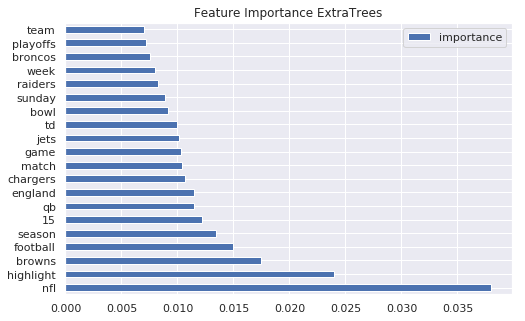

In [165]:

feature_importances[feature_importances['importance'] > 0].head(20).plot(kind='barh', title= 'Feature Importance ExtraTrees',figsize=(8,5));

In [ ]:
# word cloud 